In [1]:
%run data_preparation.ipynb

Accessible dataframes    Description                            # of columns  
data_2019                Gives data for 2019-Baseline           15
data_2024                Gives data for 2024                    13
station_data             Existing stations in NYC from Lyft      6


In [6]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster


In [7]:
file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2020.pkl"
data_2020 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2021.pkl"
data_2021 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2022.pkl"
data_2022 = pd.read_pickle(file_name)

file_name = "C:/Users/lukas/OneDrive - Imperial College London/0_Data/Old_data/data_2023.pkl"
data_2023 = pd.read_pickle(file_name)

MemoryError: 

## Further Data Cleaning

In [4]:
data_2019.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                  float64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                           category
usertype                         category
birth year                          int64
gender                           category
dtype: object

In [18]:
# Print summary statistics
print(data_2019.describe())

# Check for any remaining missing values
print(data_2019.isnull().sum())

# Check for any remaining duplicates
print(data_2019.duplicated().sum())

       tripduration                      starttime  \
count  2.055170e+07                       20551697   
mean   9.782455e+02  2019-07-12 13:38:14.879607296   
min    6.100000e+01     2019-01-01 00:01:47.401000   
25%    3.620000e+02  2019-05-03 07:06:23.523000064   
50%    6.150000e+02  2019-07-18 11:44:48.559000064   
75%    1.079000e+03  2019-09-23 19:30:41.959000064   
max    3.812666e+06     2019-12-31 23:59:55.296000   
std    1.055304e+04                            NaN   

                            stoptime  start station id  \
count                       20551697      2.055152e+07   
mean   2019-07-12 13:54:33.631335680      1.663465e+03   
min       2019-01-01 00:07:07.581000      7.200000e+01   
25%       2019-05-03 07:18:43.400000      3.820000e+02   
50%    2019-07-18 11:59:51.628999936      5.140000e+02   
75%    2019-09-23 19:47:18.051000064      3.295000e+03   
max       2020-01-17 20:00:05.082000      3.911000e+03   
std                              NaN      1.47733

In [10]:
columns_with_missing_values = data_2019.columns[data_2019.isna().any()].tolist()
print("Columns with missing values:")
print(columns_with_missing_values)

# Count the number of missing values in each column
na_count = data_2019.isna().sum()

# Print the number of missing values for each column
print("\nNumber of missing values in each column:")
print(na_count)


Columns with missing values:
['start station id', 'start station name', 'end station id', 'end station name']

Number of missing values in each column:
tripduration                 0
starttime                    0
stoptime                     0
start station id           180
start station name         180
start station latitude       0
start station longitude      0
end station id             180
end station name           180
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64


In [16]:
data_nan_location = data_2019[data_2019.isna().any(axis=1)]
data_nan_location

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
248483,2358,2019-01-08 13:48:13.812,2019-01-08 14:27:32.016,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.881,34550,Subscriber,1992,1
249690,3358,2019-01-08 14:29:31.515,2019-01-08 15:25:29.713,NaN,NaN,40.857,-73.884,NaN,NaN,40.857,-73.884,34550,Subscriber,1992,1
336359,596,2019-01-10 14:35:39.212,2019-01-10 14:45:35.413,NaN,NaN,40.863,-73.890,NaN,NaN,40.866,-73.884,34550,Subscriber,1986,1
337008,816,2019-01-10 14:56:38.425,2019-01-10 15:10:14.812,NaN,NaN,40.857,-73.890,NaN,NaN,40.854,-73.902,34447,Subscriber,1986,1
396461,393,2019-01-12 12:36:01.144,2019-01-12 12:42:34.952,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.884,34536,Customer,1997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13292288,419,2019-08-28 04:56:24.076,2019-08-28 05:03:23.578,NaN,NaN,40.860,-73.899,NaN,NaN,40.860,-73.887,34428,Customer,1998,1
13292321,856,2019-08-28 05:05:22.354,2019-08-28 05:19:39.288,NaN,NaN,40.860,-73.887,NaN,NaN,40.848,-73.908,34428,Customer,1998,1
13292453,949,2019-08-28 05:23:29.688,2019-08-28 05:39:19.687,NaN,NaN,40.848,-73.908,NaN,NaN,40.854,-73.902,34428,Customer,1998,1
13293165,739,2019-08-28 06:09:32.525,2019-08-28 06:21:52.251,NaN,NaN,40.854,-73.899,NaN,NaN,40.848,-73.902,34428,Customer,1998,1


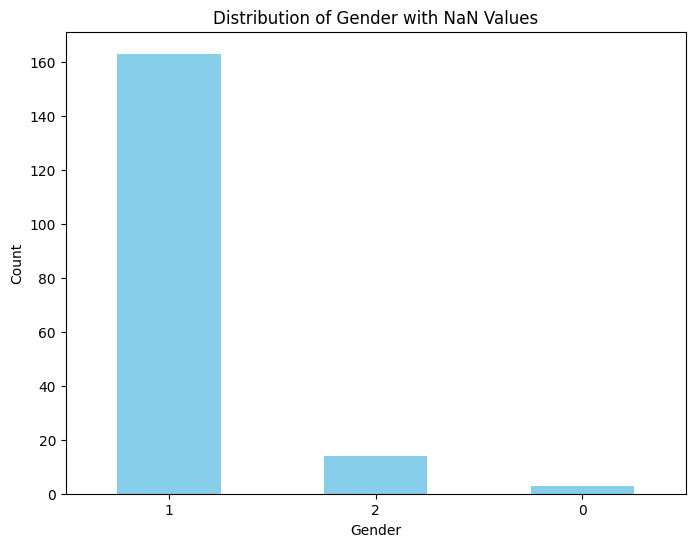

In [21]:
plt.figure(figsize=(8, 6))
data_nan_location['gender'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Gender with NaN Values')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [19]:
data_nan_location.describe()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,birth year
count,180.000000,180,180,0.0,180.000000,180.000000,0.0,180.000000,180.000000,180.000000
mean,1092.888889,2019-07-02 11:46:25.789355520,2019-07-02 12:04:39.151472384,NaN,40.857283,-73.893050,NaN,40.857100,-73.892983,1989.244444
min,80.000000,2019-01-08 13:48:13.812000,2019-01-08 14:27:32.016000,NaN,40.842000,-73.914000,NaN,40.842000,-73.914000,1969.000000
25%,403.250000,2019-07-25 16:19:02.836999936,2019-07-25 16:26:27.315749888,NaN,40.854000,-73.896750,NaN,40.854000,-73.896000,1984.500000
50%,693.000000,2019-07-31 18:03:04.578999808,2019-07-31 18:14:37.983500032,NaN,40.857000,-73.893000,NaN,40.857000,-73.893000,1992.000000
75%,1347.500000,2019-08-15 15:17:36.016250112,2019-08-15 15:32:10.785999872,NaN,40.863000,-73.890000,NaN,40.863000,-73.890000,1997.000000
max,10716.000000,2019-08-29 13:02:19.993000,2019-08-29 13:10:14.022000,NaN,40.869000,-73.878000,NaN,40.869000,-73.878000,2003.000000
std,1227.339084,NaN,NaN,NaN,0.006450,0.007193,NaN,0.006719,0.007331,9.093937


In [ ]:
# Handle outliers
# Example: Clip tripduration to remove outliers
tripduration_mean = data_2019['tripduration'].mean()
tripduration_std = data_2019['tripduration'].std()
lower_bound = tripduration_mean - 3 * tripduration_std
upper_bound = tripduration_mean + 3 * tripduration_std
data_2019['tripduration'] = data_2019['tripduration'].clip(lower=lower_bound, upper=upper_bound)

# Convert birth year to age
current_year = pd.Timestamp.now().year
data_2019['age'] = current_year - data_2019['birth year']

# Remove rows with invalid ages (e.g., negative age)
data_2019 = data_2019[data_2019['age'] >= 0]

# Drop unnecessary columns
data_2019 = data_2019.drop(columns=['birth year'])

# Print summary statistics
print(data_2019.describe())

# Check for any remaining missing values
print(data_2019.isnull().sum())

# Check for any remaining duplicates
print(data_2019.duplicated().sum())

# Colourful Map from 2019-2024

In [10]:
data_2019_t = data_2019.drop_duplicates(subset='start station name')
data_2020_t = data_2020.drop_duplicates(subset='start station name')
data_2021_t = data_2021.drop_duplicates(subset='start station name')
data_2022_t = data_2022.drop_duplicates(subset='start_station_name')
data_2023_t = data_2023.drop_duplicates(subset='start_station_name')
data_2024_t = data_2024.drop_duplicates(subset='start_station_name')

In [26]:
data_2019_t = data_2019_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})
data_2020_t = data_2020_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})
data_2021_t = data_2021_t.rename(columns={'start station latitude': 'start_lat', 'start station longitude': 'start_lng'})

In [57]:
data_2019_t = data_2019_t.dropna(subset=['start_lat'])
data_2020_t = data_2020_t.dropna(subset=['start_lat'])
data_2021_t = data_2021_t.dropna(subset=['start_lat'])
data_2022_t = data_2022_t.dropna(subset=['start_lat'])
data_2023_t = data_2023_t.dropna(subset=['start_lat'])
data_2024_t = data_2024_t.dropna(subset=['start_lat'])

data_2019_t = data_2019_t[['start_lat','start_lng']]
data_2020_t = data_2020_t[['start_lat','start_lng']]
data_2021_t = data_2021_t[['start_lat','start_lng']]
data_2022_t = data_2022_t[['start_lat','start_lng']]
data_2023_t = data_2023_t[['start_lat','start_lng']]
data_2024_t = data_2024_t[['start_lat','start_lng']]

In [70]:
station_dataframes = {
    2019: data_2019_t,
    2020: data_2020_t,
    # 2021: data_2021_t,
    2022: data_2022_t,
    2023: data_2023_t,
    # 2024: data_2024_t
}

In [71]:
# Create a map centered at a default location
map_center = [40.7, -73.9]  # Default center for New York City
m = folium.Map(location=map_center, zoom_start=11)

# Define colors for each year
colors = {2019: 'green', 2020: 'blue', 2022: 'violet', 2023: 'orangered'} # ,2021: 'blueviolet'   ,2024: 'gold'
# Add more colors for additional years if necessary

# Initialize a set to store unique station coordinates
unique_stations = set()
for year, df in sorted(station_dataframes.items()):
    # Calculate new stations for the current year compared to the previous year
    new_stations = set(zip(df['start_lat'], df['start_lng'])) - unique_stations
    
    # Iterate over new stations
    for lat, lon in new_stations:
        # Create a marker with a popup showing the year
        folium.CircleMarker(location=[lat, lon], radius=1, color=colors[year], fill=True, fill_color=colors[year],
                            fill_opacity=0.6, popup=f'Year: {year}').add_to(m)
        
        # Add new station coordinates to the set of unique stations
        unique_stations.add((lat, lon))

# Save the map to an HTML file
m.save('new_station_map_no_clustering.html')